# CCSN [sncosmo](https://sncosmo.readthedocs.io) Models

Specify sncosmo flux using the r-band apparent magnitude.

In [26]:
from sncosmo.models import Model

from astropy import units as u
from astropy.table import Table

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [22]:
mpl.rc('font', size=16)

## Example Instantiation of One Model

In [134]:
mod = Model('v19-2009ip-corr')

# Set redshift and apparent magnitude in the r-band, using SDSS filter.
mod.set(z=0.1)
mod.set_source_peakmag(18, 'sdssr', 'AB')

# Compute wavelength and flux.
wave = np.arange(3800,9800) * u.Angstrom
flux = mod.flux(0, wave)

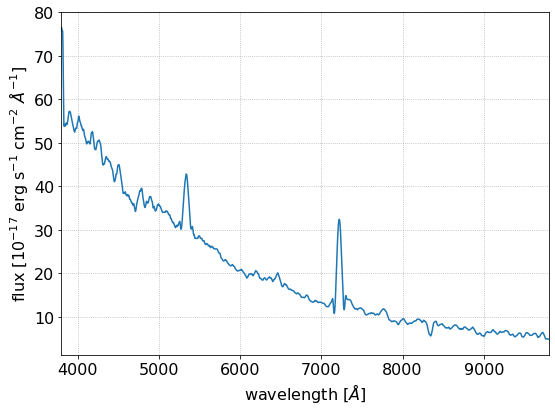

In [25]:
fig, ax = plt.subplots(1,1, figsize=(8,6), tight_layout=True)
ax.plot(wave, flux*1e17)
ax.set(xlabel=r'wavelength [$\AA$]',
       xlim=[wave[0].to_value('Angstrom'), wave[-1].to_value('Angstrom')],
       ylabel=r'flux [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')
ax.grid(ls=':');

## Read in CCSN Models

Access the model list from [Vincenzi et al., MRNAS:489(4) 5802, 2019](https://arxiv.org/abs/1908.05228).

Remove models which don't look fantastic according to visual inspection. E.g., odd artifacts at particular phases of the explosions, very noisy signals, clear evidence of awkward extrapolation, etc.

In [82]:
# Import models from Vincenzo et al.
modtab = Table.read('vincenzi_2019_models.fits')

faulty = ['SN2013by','SN2013fs','SN2009bw','SN2012aw','SN2009kr','ASASSN14jb','SN2013am','SN2008ax','SN2008fq','SN2009ip','IPTF13bvn','SN2008D','SN1994I',
'SN2007gr','SN2009bb','SN2007ru']
select = [x not in faulty for x in modtab['Name']]

# Black list some of the models. Create the key needed to set up sncosmo.
modtab = modtab[select]
modtab

Name,Type,Redshift,Peak MB,Optical data,Near-UV data,Nspectra,EBV
bytes10,bytes8,float64,float64,bytes13,bytes20,int64,float64
ASASSN15oz,II,0.00693,-18.19,UBVRIgri,"u,b,v,uvw1,uvm2,uvw2",13,0.0
SN2014G,II,0.00563,-18.1,UBVRI,"v,uvw1,uvm2,uvw2",17,0.24
SN2007od,II,0.00586,-17.93,UBVRIri,"u,b,v,uvw1,uvm2,uvw2",13,0.0
SN2013ej,II,0.00219,-17.76,UBVRIgriz,"u,b,v,uvw1,uvm2,uvw2",28,0.049
SN2008bj,II,0.019,-17.48,UBVri,,16,0.081
SN2016X,II,0.00441,-17.38,UBVRIgri,"u,b,v,uvw1,uvm2,uvw2",33,0.02
SN2013ab,II,0.00532,-17.14,BVRIgri,"u,b,uvw1,uvm2,uvw2",22,0.02
SN2004et,II,0.00105,-17.09,UBVRI,,28,0.07
SN2008in,II,0.00522,-16.96,BVri,"u,b,v,uvw1,uvm2,uvw2",10,0.076


## Sort Models by Spectral Type

In [88]:
modtypes, counts = np.unique(modtab['Type'], return_counts=True)
for mt, c in zip(modtypes, counts):
    print('{:10} {}'.format(mt, c))

87A-like   1
II         15
IIb        10
IIn        4
Ib         12
Ic         5
Ic-BL      4


## Make a dictionary of types and available model names.

In [89]:
modlist = {}
for mt in modtypes:
    select = modtab['Type'] == mt
    typelist = ['v19-{}-corr'.format(x[2:].lower()) if x.startswith('SN') else 'v19-{}-corr'.format(x.lower()) \
                for x in modtab[select]['Name']]
    modlist[mt] = typelist

## Loop through Models and Instantiate

Test whether or not we can build these built-in sncosmo models by name.

If we can, plot the flux as a function of wavelength at different phases in the explosion. For the sake of consistency, put all the objects at $z=0.1$ and give them the same apparent magnitude $r_\mathrm{AB}=18$ at the peak.

In [133]:
wave = np.arange(3800,9800) * u.Angstrom

for mt, models in modlist.items():
    print('\nInstantiating Type {} models:'.format(mt))
    for model in models:
        try:
            fig, axes = plt.subplots(6,5, figsize=(5*5, 6*3.5), sharex=True, sharey=True)
            axes = axes.flatten()

            ccsn = Model(model)
            ccsn.set(z=0.1)
            ccsn.set_source_peakmag(18, 'sdssr', 'AB')
            print('- Instantiated {}'.format(model))
            
            # Plot the flux and save the output.
            for t, ax in zip(np.arange(-10,20), axes):
                flux = ccsn.flux(t, wave)
                ax.plot(wave, flux*1e17, lw=2, label='$t={}$ days'.format(t))
                ax.set(xlim=[wave[0].to_value('Angstrom'), wave[-1].to_value('Angstrom')])
                ax.legend(loc='upper right', fontsize=12)
                ax.grid(ls=':')

            fig.suptitle(ccsn.source.name)
            fig.subplots_adjust(top=0.95, left=0.075, bottom=0.075)
            fig.text(0.5, 0.04, r'wavelength [$\AA$]', ha='center')
            fig.text(0.04, 0.5, r'flux [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]', va='center', rotation='vertical')

            fig.savefig('ccsnfigs/{}.pdf'.format(ccsn.source.name))
            plt.close(fig=fig)
        except Exception as e:
            print(e)


Instantiating Type 87A-like models:
- Instantiated v19-1987a-corr

Instantiating Type II models:
- Instantiated v19-asassn15oz-corr
- Instantiated v19-2014g-corr
- Instantiated v19-2007od-corr
- Instantiated v19-2013ej-corr
- Instantiated v19-2008bj-corr
- Instantiated v19-2016x-corr
- Instantiated v19-2013ab-corr
- Instantiated v19-2004et-corr
- Instantiated v19-2008in-corr
- Instantiated v19-2009dd-corr
- Instantiated v19-1999em-corr
- Instantiated v19-2012a-corr
- Instantiated v19-2009ib-corr
- Instantiated v19-2009n-corr
- Instantiated v19-2016bkv-corr

Instantiating Type IIb models:
- Instantiated v19-2011fu-corr
- Instantiated v19-2006t-corr
- Instantiated v19-2016gkg-corr
- Instantiated v19-2008aq-corr
- Instantiated v19-2011ei-corr
- Instantiated v19-2011dh-corr
- Instantiated v19-2013df-corr
- Instantiated v19-2011hs-corr
- Instantiated v19-2008bo-corr
- Instantiated v19-1993j-corr

Instantiating Type IIn models:
- Instantiated v19-2010al-corr
- Instantiated v19-2007pk-corr
-